# **Importing Python Modules**

In [ ]:
!pip install openai
!pip install gpt_index
!pip install catboost

In [ ]:
import pandas as pd # Dataframe support in Python
import numpy as np # Array support in python
import sklearn  # Machine learning
import gdown # Downloading dataset from google drive
import matplotlib.pyplot as plt # For visualization figures
from matplotlib.pyplot import figure # For visualization figures
from gpt_index import SimpleDirectoryReader, GPTListIndex, GPTSimpleVectorIndex, LLMPredictor, PromptHelper
from langchain import OpenAI
import openai
import sys
import os
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import nltk
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
#from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from datetime import datetime

# **Downloading Dataset**

*Downloading dataset from Google Drive*

---



In [ ]:
# Drive Link: https://drive.google.com/file/d/1rEXGrjlZ5BjRLNCXIQ6YDieQkOEEL0Ls/view?usp=sharing
url = 'https://drive.google.com/uc?id=1rEXGrjlZ5BjRLNCXIQ6YDieQkOEEL0Ls'
output = 'Dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1rEXGrjlZ5BjRLNCXIQ6YDieQkOEEL0Ls
To: /content/Dataset.zip
100%|██████████| 485k/485k [00:00<00:00, 84.1MB/s]


'Dataset.zip'

*Unzipping dataset*

---



In [ ]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Apache/
  inflating: __MACOSX/._Apache       
  inflating: Apache/Apache_2k.log_templates.csv  
  inflating: __MACOSX/Apache/._Apache_2k.log_templates.csv  
  inflating: Apache/Apache_2k.log    
  inflating: __MACOSX/Apache/._Apache_2k.log  
  inflating: Apache/Apache_2k.log_structured.csv  
  inflating: __MACOSX/Apache/._Apache_2k.log_structured.csv  
   creating: BGL/
  inflating: __MACOSX/._BGL          
  inflating: BGL/BGL_templates.csv   
  inflating: __MACOSX/BGL/._BGL_templates.csv  
  inflating: BGL/BGL_2k.log          
  inflating: __MACOSX/BGL/._BGL_2k.log  
  inflating: BGL/BGL_2k.log_templates.csv  
  inflating: __MACOSX/BGL/._BGL_2k.log_templates.csv  
  inflating: BGL/BGL_2k.log_structured.csv  
  inflating: __MACOSX/BGL/._BGL_2k.log_structured.csv  
   creating: Hadoop/
  inflating: __MACOSX/._Hadoop       
  inflating: Hadoop/Hadoop_2k.log_structured.csv  
  inflating: __MACOSX/Hadoop/._Hadoop_2k.log_structured.csv  
  inflating: Hado

In [ ]:
# Importing the dataset into dataframe
apache = pd.read_csv("/content/Apache/Apache_2k.log_structured.csv", index_col=0)
bgl = pd.read_csv("/content/BGL/BGL_2k.log_structured.csv", index_col=0)
hdfs = pd.read_csv("/content/HDFS/HDFS_2k.log_structured.csv", index_col=0)
thunderbird = pd.read_csv("/content/Thunderbird/Thunderbird_2k.log_structured.csv", index_col=0)

# **GPT**

In [ ]:
pd.set_option('display.max_colwidth', 10000)
MAX_COMMENT_LEN = 1024
openai.api_key = 'Your API Key' #Insert your API key here
MAX_COMMENTS_TO_PROCESS = 2000000
ENGINE = 'text-similarity-ada-001'
DEBUG = False

ENGINE_PRICE_PER_TOKEN = {
    'text-similarity-davinci-001': 0.6 / 1000,
    'text-similarity_curie-001': 0.06 / 1000,
    'text-similarity-babbage-001': 0.012 / 1000,
    'text-similarity-ada-001': 0.008 / 1000
}

In [ ]:
def gen_embeddings(comments, engine):
    if DEBUG:
        return np.random.randn(len(comments), 1024)
    else:
        return np.array([d['word_embedding'] for d in openai.Embedding.create(input=comments.tolist(), engine=engine)['data']]), np.array([d['sentence_embedding'] for d in openai.Embedding.create(input=comments.tolist(), engine=engine)['data']])

# **Generating Word & Sentence Embedding from GPT**

In [ ]:
word_embs = []
sentence_emb = []

for apache in tqdm(np.array_split(apache, len(apache) // 100)):
    word_embs.append(gen_embeddings(apache['Content'], ENGINE))
    sentence_emb.append(gen_embeddings(apache['Content'], ENGINE))
word_embs = np.concatenate(word_embs)
sentence_emb = np.concatenate(sentence_emb)

  0%|          | 0/1999 [00:00<?, ?it/s]

# **Clustering with K-Means & Labeling**

In [ ]:
# Initializes KMeans algorithm with 2 clusters
kmeans = KMeans(n_clusters=2)
# Fits the data sentence_emb to the KMeans algorithm
kmeans.fit(sentence_emb)
# Predicts the cluster labels for the data sentence_emb
y_kmeans = kmeans.predict(sentence_emb)
# Returns the centroids of the 2 clusters found by KMeans
kmeans.cluster_centers_

array([[-0.14173381, -0.27829923],
       [-1.00075489,  0.93424855]])

# **Tagging & Sequence Labeling**

In [ ]:
pos_tags = nltk.pos_tag(word_emb)
seq_label = word_emb.concatenate(sentence_emb)
seq_label = seq_label.concatenate(seq_label)

# **1. Apache**

## **Train-Test Split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(seq_label, y_kmeans, test_size=0.2)

## **Classification**

### **Random Forest**



> **Training Random Forest and Testing on unseen data**



In [ ]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 100.0
Test Accuracy: 98.0




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.983516  0.972826  0.978142       184
           1   0.977064  0.986111  0.981567       216

    accuracy                       0.980000       400
   macro avg   0.980290  0.979469  0.979854       400
weighted avg   0.980032  0.980000  0.979991       400





> **Confusion Matrix**



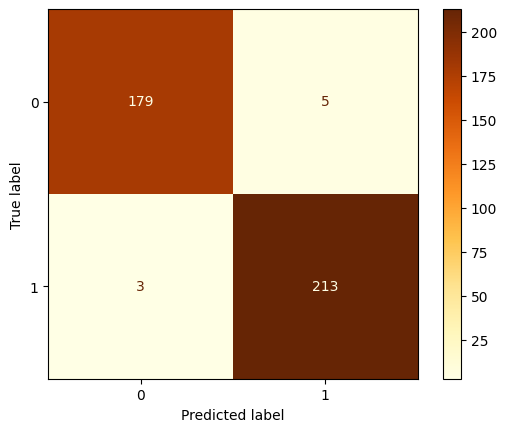

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.YlOrBr)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.995


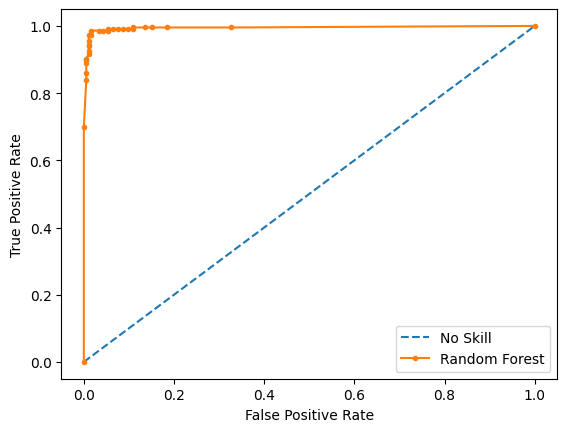

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.024524


### **LightGBM**



> **Training LightGBM and Testing on unseen data**



In [ ]:
clf = LGBMClassifier()
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 100.0
Test Accuracy: 98.5




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.989362  0.978947  0.984127       190
           1   0.981132  0.990476  0.985782       210

    accuracy                       0.985000       400
   macro avg   0.985247  0.984712  0.984954       400
weighted avg   0.985041  0.985000  0.984996       400





> **Confusion Matrix**



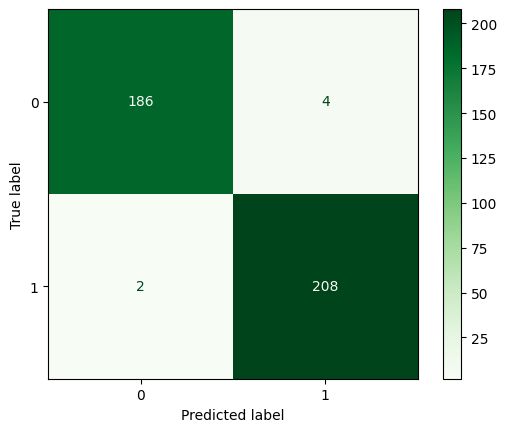

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.Greens)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
LightGBM: ROC AUC=0.988


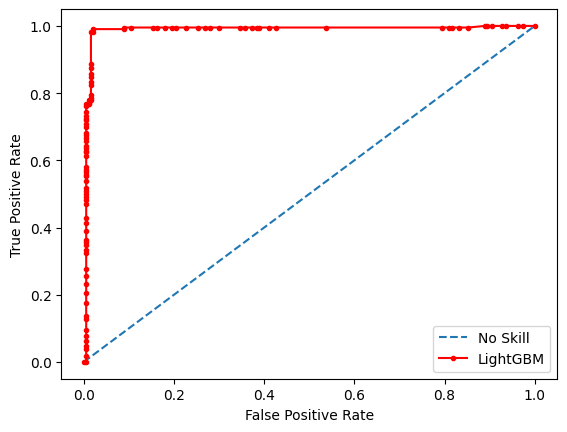

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LightGBM: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LightGBM', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.007038


### **CatBoost**



> **Training CatBoost and Testing on unseen data**



In [ ]:
clf = CatBoostClassifier(verbose=0)
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 99.0625
Test Accuracy: 99.75




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   1.000000  0.994737  0.997361       190
           1   0.995261  1.000000  0.997625       210

    accuracy                       0.997500       400
   macro avg   0.997630  0.997368  0.997493       400
weighted avg   0.997512  0.997500  0.997500       400





> **Confusion Matrix**



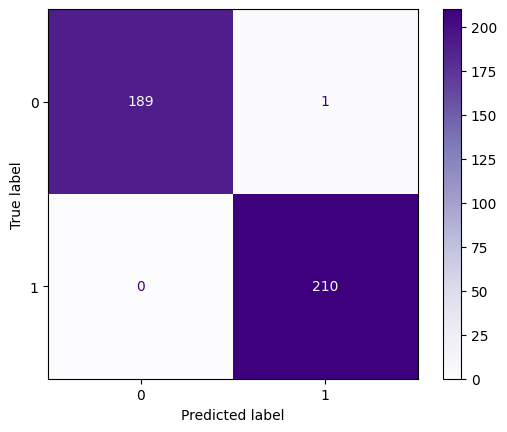

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.Purples)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
CatBoost: ROC AUC=0.998


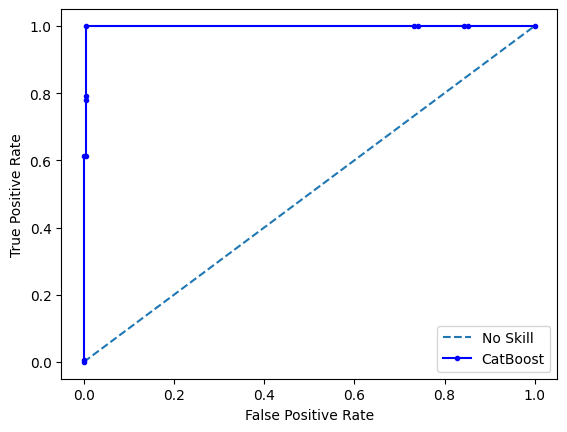

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('CatBoost: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.010937


# **2. BGL**

## **Train-Test Split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(seq_label, y_kmeans, test_size=0.2)

## **Classification**

### **Random Forest**



> **Training Random Forest and Testing on unseen data**



In [ ]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 100.0
Test Accuracy: 98.75




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.979592  0.994819  0.987147       193
           1   0.995098  0.980676  0.987835       207

    accuracy                       0.987500       400
   macro avg   0.987345  0.987747  0.987491       400
weighted avg   0.987616  0.987500  0.987503       400





> **Confusion Matrix**



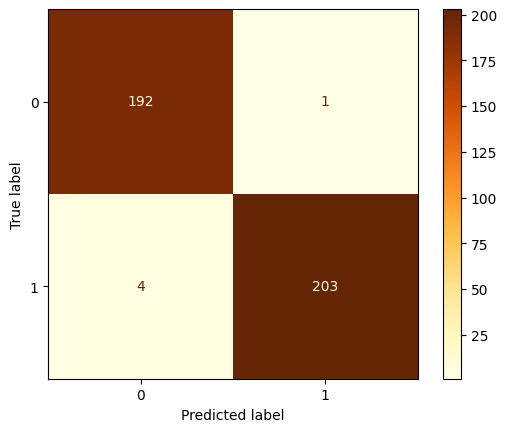

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.YlOrBr)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.993


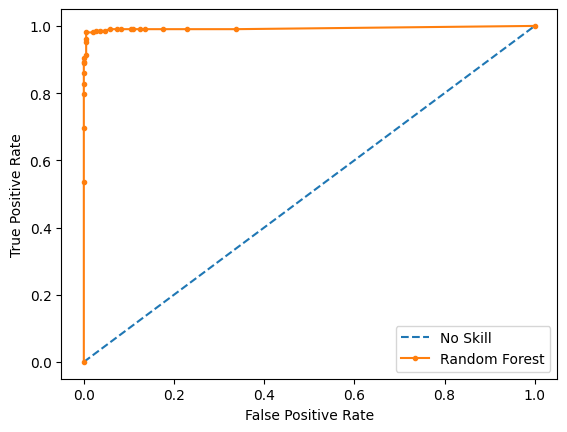

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.019798


### **LightGBM**



> **Training LightGBM and Testing on unseen data**



In [ ]:
clf = LGBMClassifier()
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 100.0
Test Accuracy: 97.75




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.974227  0.979275  0.976744       193
           1   0.980583  0.975845  0.978208       207

    accuracy                       0.977500       400
   macro avg   0.977405  0.977560  0.977476       400
weighted avg   0.977516  0.977500  0.977502       400





> **Confusion Matrix**



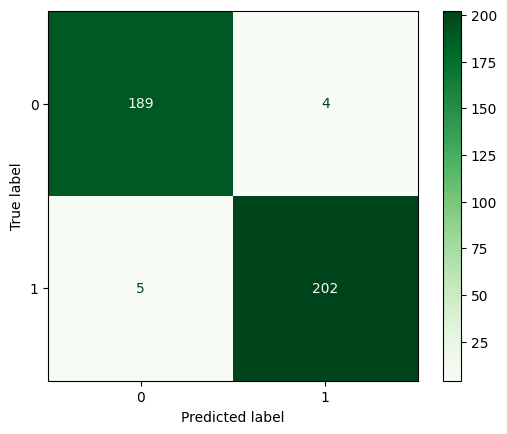

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.Greens)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
LightGBM: ROC AUC=0.995


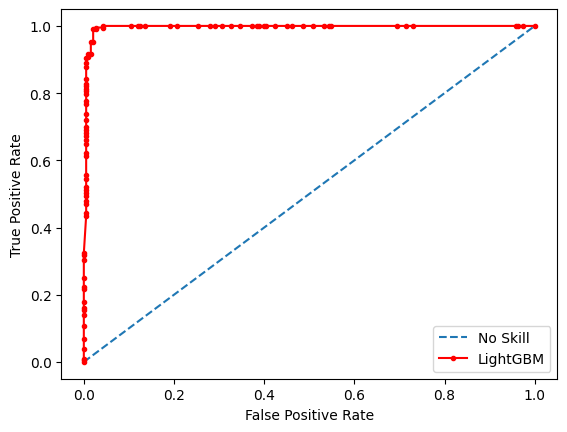

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LightGBM: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LightGBM', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.025235


### **CatBoost**



> **Training CatBoost and Testing on unseen data**



In [ ]:
clf = CatBoostClassifier(verbose=0)
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 99.0
Test Accuracy: 99.0




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.989474  0.989474  0.989474       190
           1   0.990476  0.990476  0.990476       210

    accuracy                       0.990000       400
   macro avg   0.989975  0.989975  0.989975       400
weighted avg   0.990000  0.990000  0.990000       400





> **Confusion Matrix**



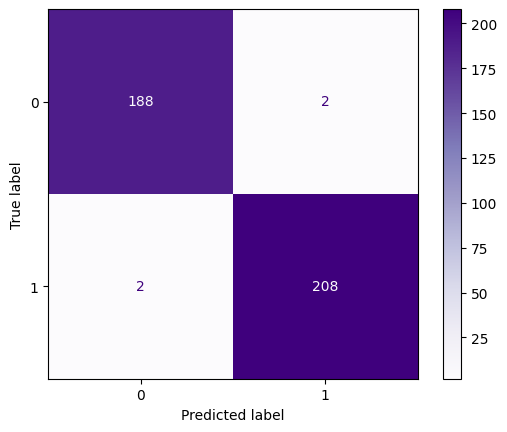

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.Purples)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
CatBoost: ROC AUC=0.999


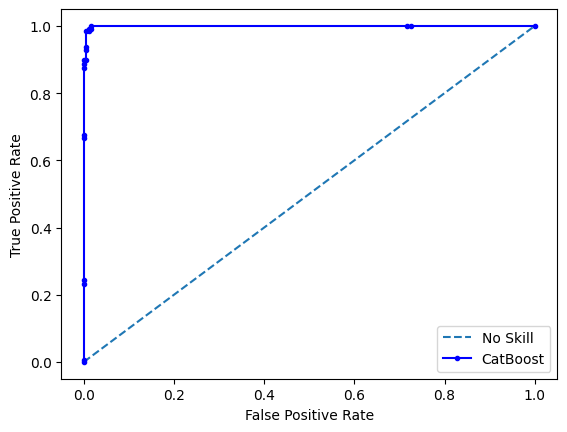

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('CatBoost: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.005348


# **3. HDFS**

## **Train-Test Split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(seq_label, y_kmeans, test_size=0.2)

## **Classification**

### **Random Forest**



> **Training Random Forest and Testing on unseen data**



In [ ]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 100.0
Test Accuracy: 98.75




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.994737  0.979275  0.986945       193
           1   0.980952  0.995169  0.988010       207

    accuracy                       0.987500       400
   macro avg   0.987845  0.987222  0.987477       400
weighted avg   0.987603  0.987500  0.987496       400





> **Confusion Matrix**



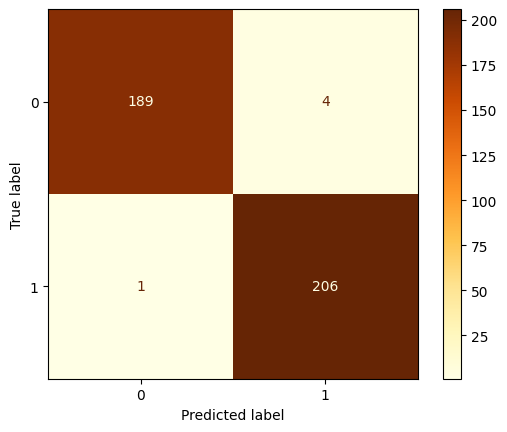

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.YlOrBr)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.989


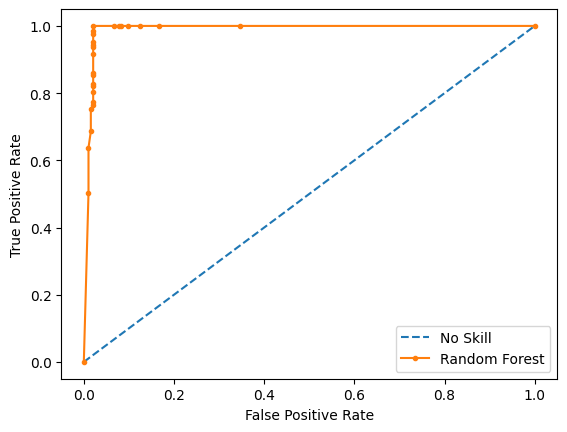

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.027765


### **LightGBM**



> **Training LightGBM and Testing on unseen data**



In [ ]:
clf = LGBMClassifier()
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 99.875
Test Accuracy: 97.0




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.988506  0.945055  0.966292       182
           1   0.955752  0.990826  0.972973       218

    accuracy                       0.970000       400
   macro avg   0.972129  0.967940  0.969633       400
weighted avg   0.970655  0.970000  0.969933       400





> **Confusion Matrix**



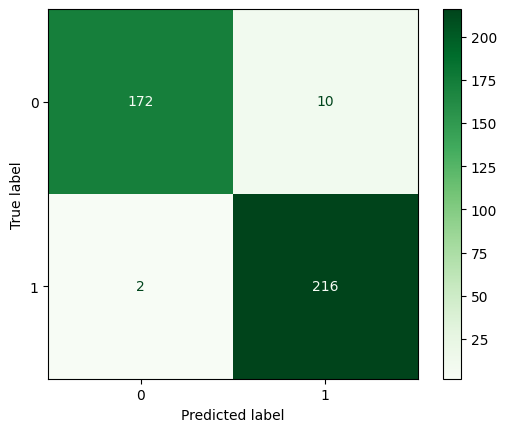

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.Greens)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
LightGBM: ROC AUC=0.989


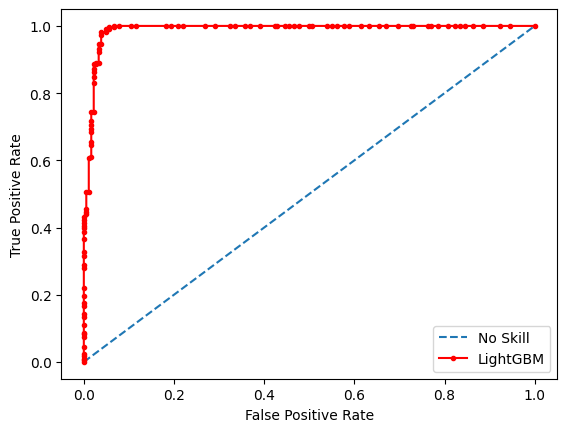

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LightGBM: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LightGBM', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.035475


### **CatBoost**



> **Training CatBoost and Testing on unseen data**



In [ ]:
clf = CatBoostClassifier(verbose=0)
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 99.0625
Test Accuracy: 97.5




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.976608  0.965318  0.970930       173
           1   0.973799  0.982379  0.978070       227

    accuracy                       0.975000       400
   macro avg   0.975204  0.973848  0.974500       400
weighted avg   0.975014  0.975000  0.974982       400





> **Confusion Matrix**



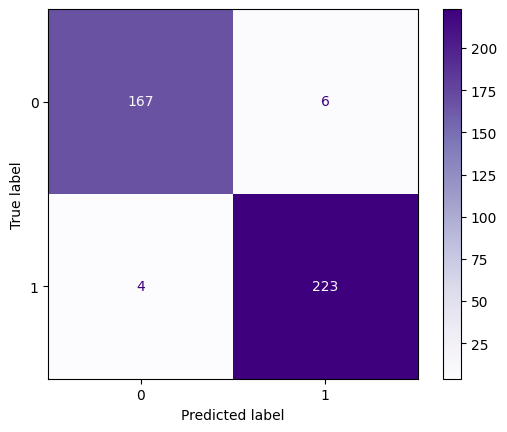

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.Purples)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
CatBoost: ROC AUC=0.984


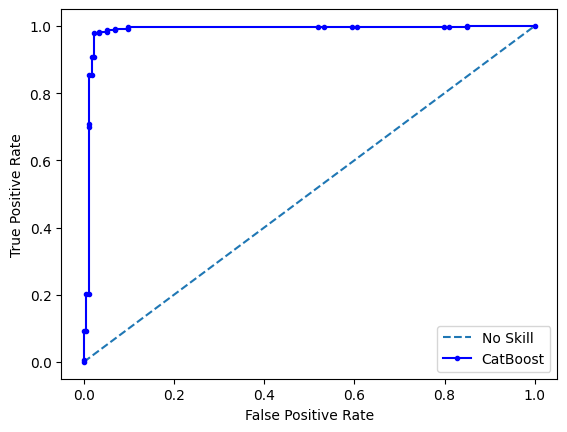

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('CatBoost: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.007264


# **4. Thunderbird**

## **Train-Test Split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(seq_label, y_kmeans, test_size=0.2)

## **Classification**

### **Random Forest**



> **Training Random Forest and Testing on unseen data**



In [ ]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 100.0
Test Accuracy: 99.33330000000001




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.996416  0.989324  0.992857       281
           1   0.990654  0.996865  0.993750       319

    accuracy                       0.993333       600
   macro avg   0.993535  0.993095  0.993304       600
weighted avg   0.993353  0.993333  0.993332       600





> **Confusion Matrix**



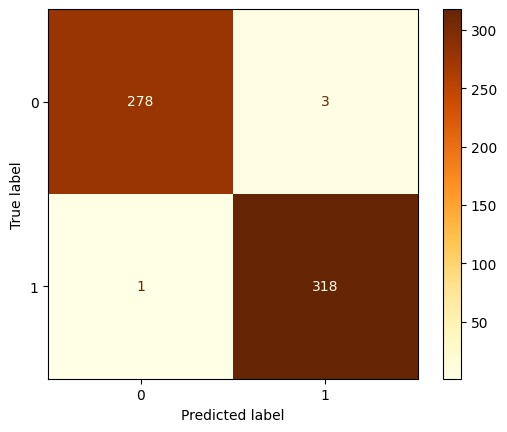

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.YlOrBr)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.994


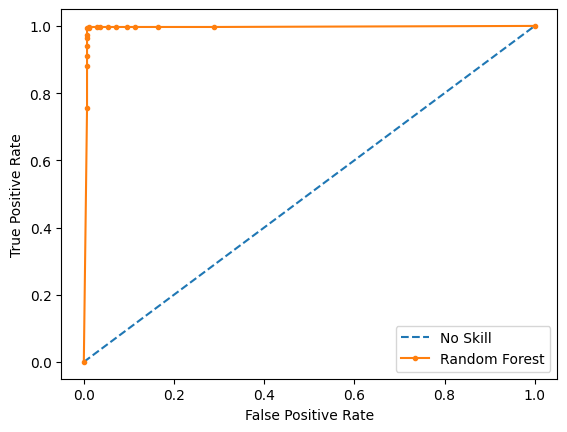

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.024687


### **LightGBM**



> **Training LightGBM and Testing on unseen data**



In [ ]:
clf = LGBMClassifier()
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 100.0
Test Accuracy: 99.0




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.992832  0.985765  0.989286       281
           1   0.987539  0.993730  0.990625       319

    accuracy                       0.990000       600
   macro avg   0.990185  0.989748  0.989955       600
weighted avg   0.990018  0.990000  0.989998       600





> **Confusion Matrix**



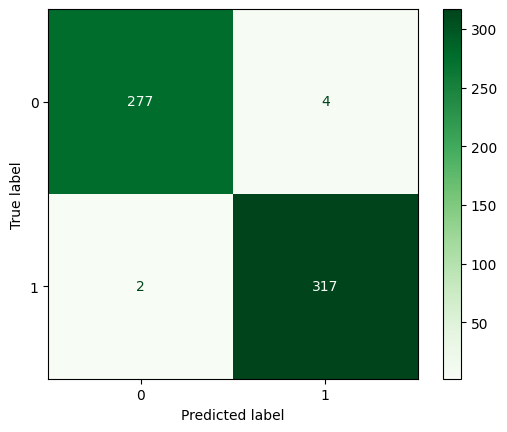

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.Greens)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
LightGBM: ROC AUC=0.994


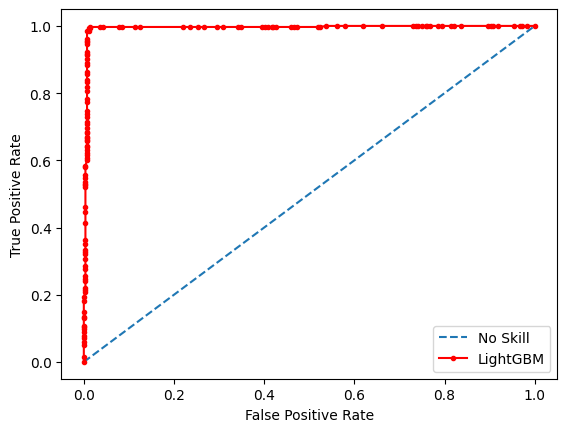

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LightGBM: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LightGBM', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.022166


### **CatBoost**



> **Training CatBoost and Testing on unseen data**



In [ ]:
clf = CatBoostClassifier(verbose=0, n_estimators=12)
clf.fit(x_train, y_train)
print("Training Score:", round(clf.score(x_train, y_train), 6) * 100)
y_predict = clf.predict(x_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_predict), 6) * 100)

Training Score: 99.1429
Test Accuracy: 99.16669999999999




> **Classification Report**



In [ ]:
print(classification_report(y_test, y_predict, digits=6))

              precision    recall  f1-score   support

           0   0.996403  0.985765  0.991055       281
           1   0.987578  0.996865  0.992200       319

    accuracy                       0.991667       600
   macro avg   0.991990  0.991315  0.991628       600
weighted avg   0.991711  0.991667  0.991664       600





> **Confusion Matrix**



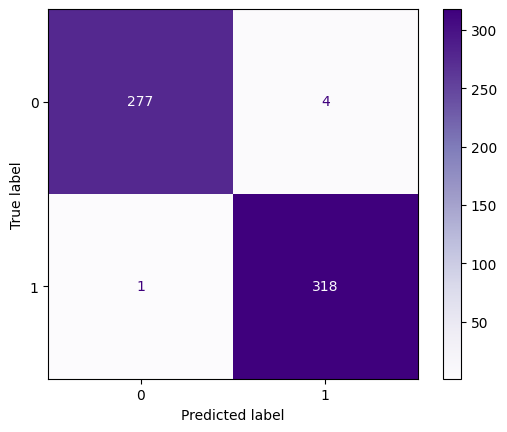

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_predict), display_labels = ['0', '1']).plot(cmap=plt.cm.Purples)



> **ROC-AUC Score**



No Skill: ROC AUC=0.500
CatBoost: ROC AUC=0.996


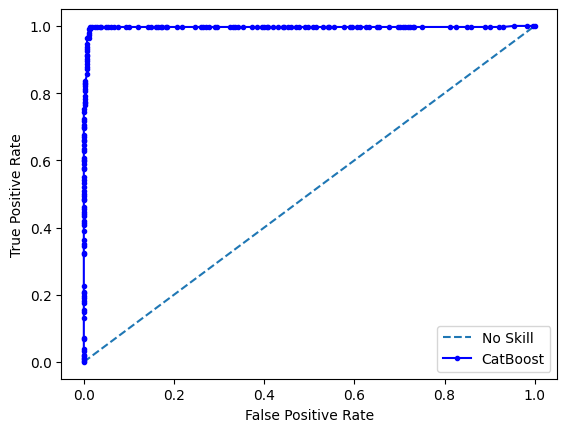

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(x_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('CatBoost: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [1]:
start = datetime.now()
y_predict = clf.predict(x_test)
print("Classification Time: ", datetime.now() - start)

Classification Time:  0:00:00.005213
